This notebook demonstrates the sparse GP approximations implemented in the `GaussianProcesses.jl`.
We will simulate a dataset, fit if first using
the exact representation, then fit it using sparse GPs.
For each approximation, this will show the tradeoffs involved,
and the performance gains.

In [1]:
# imports and set up plots
using Distributions
using LinearAlgebra: diag
using Random
using GaussianProcesses
import Statistics

import PyPlot; plt=PyPlot
using LaTeXStrings
cbbPalette = ["#E69F00", "#56B4E9", "#009E73", 
                "#F0E442", "#0072B2", "#D55E00", 
                "#CC79A7"];

# Simulated data

We start by simulating some arbitrary data, with large noise
and a fairly large sample size (n=5,000) so the
effects of the approximations are clear.

In [2]:
""" The true function we will be simulating from. """
function fstar(x::Float64)
    return abs(x-5)*cos(2*x)
end

σy = 10.0
n=5000

Random.seed!(1) # for reproducibility
Xdistr = Beta(7,7)
ϵdistr = Normal(0,σy)
x = rand(Xdistr, n)*10
X = Matrix(x')
Y = fstar.(x) .+ rand(ϵdistr,n)
;

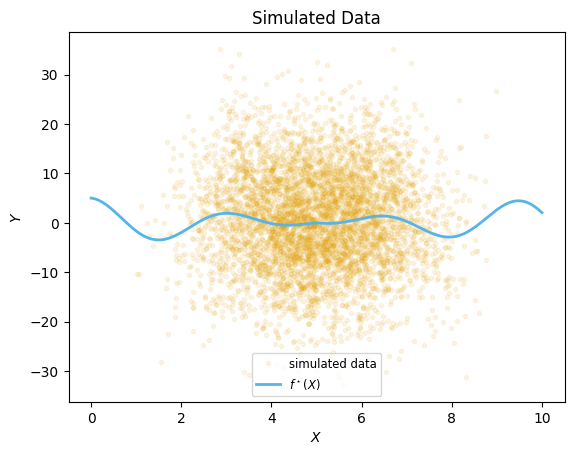

In [3]:
xx = range(0, stop=10, length=200)
plt.plot(x, Y, ".", color=cbbPalette[1], label="simulated data", alpha=0.1)
plt.plot(xx, fstar.(xx), color=cbbPalette[2], label=L"f^\star(X)", linewidth=2)
plt.xlabel(L"X")
plt.ylabel(L"Y")
plt.title("Simulated Data")
plt.legend(loc="lower center", fontsize="small")
;

# Exact GP inference

In [4]:
k = SEIso(log(0.3), log(5.0))
GPE(X, Y, MeanConst(mean(Y)), k, log(σy)) # warm-up
# time the second run (so the time doesn't include compilation):
@time gp_full = GPE(X, Y, MeanConst(mean(Y)), k, log(σy))

  1.618708 seconds (40 allocations: 572.320 MiB, 14.35% gc time)


GP Exact object:
  Dim = 1
  Number of observations = 5000
  Mean function:
    Type: MeanConst, Params: [0.56185]
  Kernel:
    Type: SEIso{Float64}, Params: [-1.20397, 1.60944]
  Input observations = 
[4.92176 5.27531 … 3.48002 5.43604]
  Output observations = [-19.283, -6.07098, 3.33402, 12.6241, -14.5596, 20.8922, -7.86136, -3.41118, -0.686436, 9.39745  …  0.160936, 10.2597, -6.34116, 0.669071, -3.28242, 4.95583, 0.739365, 2.82739, 12.3229, 11.3255]
  Variance of observation noise = 100.00000000000004
  Marginal Log-Likelihood = -18640.795

In [5]:
# extract predictions
predict_f(gp_full, xx; full_cov=true) # warm-up
@time μ_exact, Σ_exact = predict_f(gp_full, xx; full_cov=true)
;

  0.161568 seconds (79 allocations: 15.880 MiB)


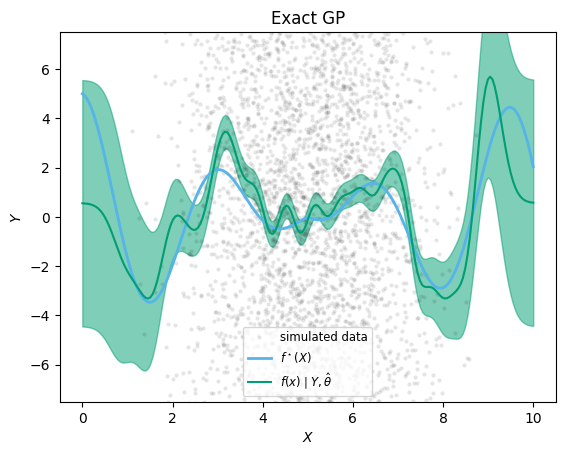

In [6]:
xx = range(0, stop=10, length=200)
plt.plot(x,Y, ".", color="black", markeredgecolor="None", alpha=0.1, label="simulated data")
plt.plot(xx, fstar.(xx), color=cbbPalette[2], label=L"f^\star(X)", linewidth=2)
plt.plot(xx, μ_exact, color=cbbPalette[3], label=L"$f(x) \mid Y, \hat\theta$")
plt.fill_between(xx, μ_exact.-sqrt.(diag(Σ_exact)), μ_exact.+sqrt.(diag(Σ_exact)), 
                 color=cbbPalette[3], alpha=0.5)
plt.xlabel(L"X")
plt.ylabel(L"Y")
plt.title("Exact GP")
plt.legend(loc="lower center", fontsize="small")
plt.ylim(-7.5,7.5)
;

The sparse Gaussian Process approximations implemented rely on the concept of inducing points, which we denote $X_u$ (an $p \times m$ matrix of inducing points, where the dimensionality $p=1$ in this example).
See the following article for a helpful introduction, from which we also use the naming conventions for the approximations:

Quiñonero-Candela, Joaquin, and Carl Edward Rasmussen. "A unifying view of sparse approximate Gaussian process regression." *Journal of Machine Learning Research* 6, no. Dec (2005): 1939-1959.

The inducing points can be randomly chosen from the data, or laid out on a grid, or even optimized as part of fitting the hyperparameters [Note: this feature is not yet available in GaussianProcesses.jl].
For illustration in this notebook, we will use quantiles of the covariate $x$:

In [7]:
Xu = Matrix(quantile(x, [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.98])')

1×12 Array{Float64,2}:
 3.82567  4.06404  4.25939  4.4478  …  5.33994  5.53788  5.73281  7.64571

We will reuse the same inducing points for all methods.

# Sparse approximations

## Subset of Regressors

We first demonstrate the subset of regressors method, the simplest and quickest approximation offered in the package.
The shortcut function `SoR(X, Xu, Y, m, k, logNoise)`
creates a Gaussian process object 

In [8]:
gp_SOR = GaussianProcesses.SoR(X, Xu, Y, MeanConst(mean(Y)), k, log(σy));
@time gp_SOR = GaussianProcesses.SoR(X, Xu, Y, MeanConst(mean(Y)), k, log(σy));

  0.002714 seconds (68 allocations: 2.032 MiB)


In this example, we see a more than 500-fold speed-up, and similarly reduced memory footprint. Generating predictions (below) is also immensely faster.
But is the approximation any good?
We show the prediction alongside the exact solution for comparison.

In [9]:
predict_f(gp_SOR, xx; full_cov=true)
@time predict_f(gp_SOR, xx; full_cov=true);

  0.000266 seconds (37 allocations: 492.828 KiB)


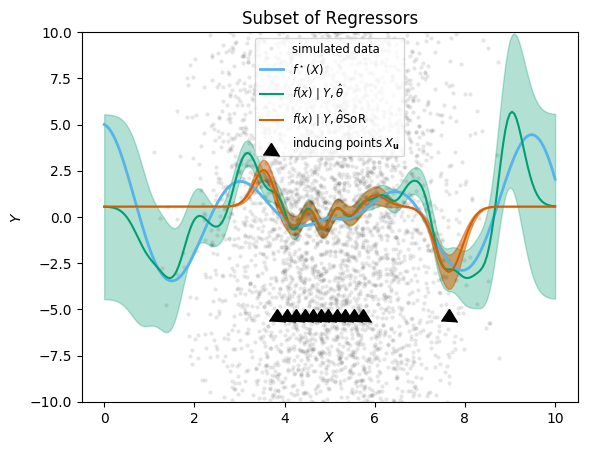

In [10]:
function plot_approximation(gp_exact, gp_approx, approx_label)
    μ_exact, Σ_exact = predict_f(gp_full, xx; full_cov=true)
    μapprox, Σapprox = predict_f(gp_approx, xx; full_cov=true)
    plt.plot(x,Y, ".", color="black", markeredgecolor="None", alpha=0.1, label="simulated data")
    plt.plot(xx, fstar.(xx), color=cbbPalette[2], label=L"f^\star(X)", linewidth=2)
    plt.plot(xx, μ_exact, color=cbbPalette[3], label=L"$f(x) \mid Y, \hat\theta$")
    plt.fill_between(xx, μ_exact.-sqrt.(diag(Σ_exact)), μ_exact.+sqrt.(diag(Σ_exact)), 
                     color=cbbPalette[3], alpha=0.3)
    plt.plot(xx, μapprox, color=cbbPalette[6], label=L"$f(x) \mid Y, \hat\theta$"*approx_label)
    y_err = sqrt.(diag(Σapprox))
    plt.fill_between(xx, μapprox.-y_err, μapprox.+y_err, 
                     color=cbbPalette[6], alpha=0.5)
    plt.xlabel(L"X")
    plt.ylabel(L"Y")
    plt.plot(vec(Xu), fill(0.0, length(Xu)).-5, linestyle="None",
        marker=6, markersize=12, color="black", label=L"inducing points $X_\mathbf{u}$")
    plt.legend(loc="upper center", fontsize="small")
    plt.ylim(-10, 10)
end
plot_approximation(gp_full, gp_SOR, "SoR")
plt.title("Subset of Regressors")
;

The locations of the inducing points are shown with black triangles (their y-coordinate is arbitrary).
The approximation is seen as the difference between the exact (green) mean prediction and credible envelop, and the predictions from SoR (orange).
We can readily see that the approximation is reasonably good near the inducing points,
but degrades quickly away from them.
Most worryingly, the extrapolation behaviour is dangerous: the posterior variance is vastly underestimated (it goes to zero), which would lead to very misleading inference results.
This is in line with the academic literature, like the Q&R 2005 article cited above.

## Deterministic Training Conditionals

We move on to the next approximation, “Deterministic Training Conditionals”, 
which does not approximate the prior variance as zero away from inducing points,
and therefore should lead to better inference.

In [11]:
gp_DTC = GaussianProcesses.DTC(X, Xu, Y, MeanConst(mean(Y)), k, log(σy));
@time gp_DTC = GaussianProcesses.DTC(X, Xu, Y, MeanConst(mean(Y)), k, log(σy));

  0.003959 seconds (70 allocations: 2.033 MiB)


In [12]:
μDTCgp, ΣDTCgp = predict_f(gp_DTC, xx; full_cov=true)
@time predict_f(gp_DTC, xx; full_cov=true);

  0.002262 seconds (61 allocations: 2.064 MiB)


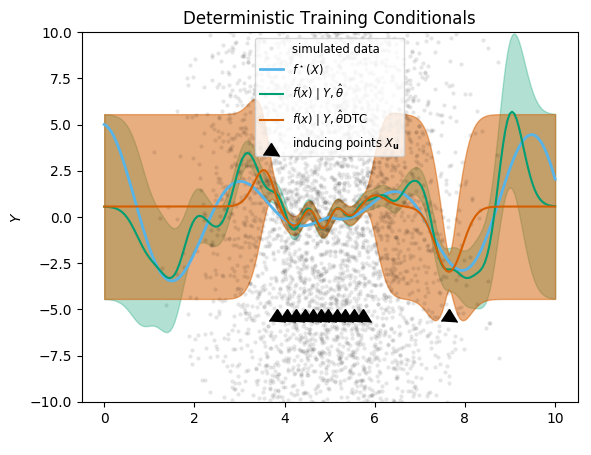

In [13]:
plot_approximation(gp_full, gp_DTC, "DTC")
plt.title("Deterministic Training Conditionals")
;

It is just as fast as SoR, but has *conservative* predictive variance away from the inducing points, which reflects the information removed by the sparse approximation, and which is safer for inference.
The mean prediction is in fact mathematically the same as in SoR, so there is no improvement there.
For these reasons, in general DTC should be preferred over SoR.

## Fully Independent Training Conditionals

The Fully Independent Training Conditionals (FITC) sparse approximation goes one step further, and adds a diagonal correction to the sparse covariance approximation of SoR and DTC (see Q&R 2005 for details).

In [14]:
gp_FITC = GaussianProcesses.FITC(X, Xu, Y, MeanConst(mean(Y)), k, log(σy));
@time gp_FITC = GaussianProcesses.FITC(X, Xu, Y, MeanConst(mean(Y)), k, log(σy));

  0.017552 seconds (10.09 k allocations: 3.902 MiB, 60.36% gc time)


In [15]:
predict_f(gp_FITC, xx; full_cov=true)
@time predict_f(gp_FITC, xx; full_cov=true);

  0.002084 seconds (63 allocations: 2.064 MiB)


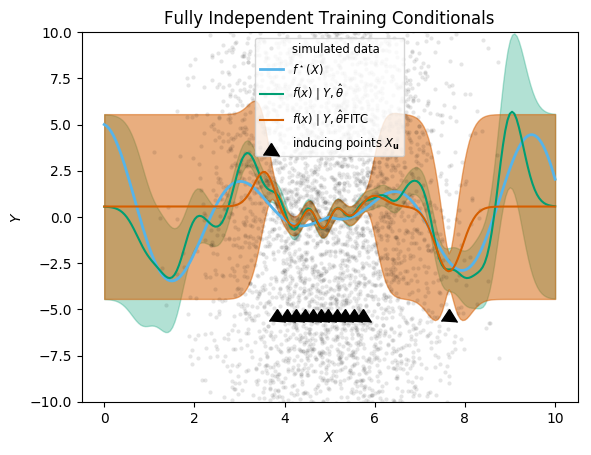

In [16]:
plot_approximation(gp_full, gp_FITC, "FITC")
plt.title("Fully Independent Training Conditionals")
;

As anticipated in Q&R 2005, the improvement over DTC is actually fairly minimal.
However, the computational time is significantly higher (though still much lower than the exact GP).
Consequently, for most applications, DTC may be preferable to FITC.

## Full Scale Approximation

The Full Scale Approximation (FSA) using the sparse approximation for long-range covariances, but is exact within smaller local blocks.
The blocks need to be chosen in addition to the inducing points.
In this notebook, we will create as many blocks as there are inducing points,
and assign each observation to the block with the nearest inducing points.

In [17]:
inearest = [argmin(abs.(xi.-Xu[1,:])) for xi in x]
blockindices = [findall(isequal(i), inearest) for i in 1:size(Xu,2)]

GaussianProcesses.FSA(X, Xu, blockindices, Y, MeanConst(mean(Y)), k, log(σy));
@time gp_FSA = GaussianProcesses.FSA(X, Xu, blockindices, Y, MeanConst(mean(Y)), k, log(σy));

  0.260956 seconds (593 allocations: 156.025 MiB, 43.57% gc time)


For predictions, we also need to provide the block indices.

In [18]:
iprednearest = [argmin(abs.(xi.-Xu[1,:])) for xi in xx]
blockindpred = [findall(isequal(i), iprednearest) 
                for i in 1:size(Xu,2)]

predict_f(gp_FSA, xx, blockindpred; full_cov=true)
@time predict_f(gp_FSA, xx, blockindpred; full_cov=true);

  0.126982 seconds (616 allocations: 92.226 MiB, 6.72% gc time)


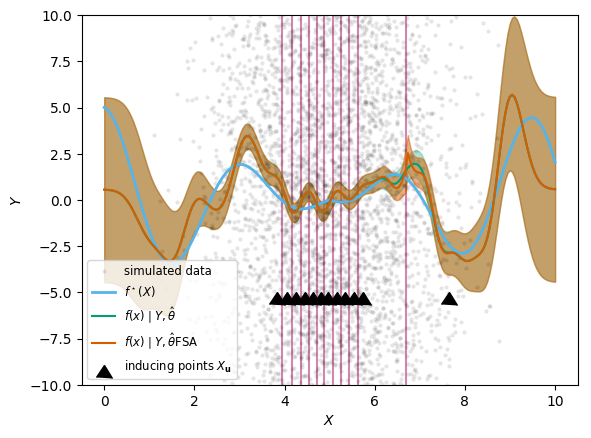

In [19]:
function plot_approximation(gp_exact, gp_approx, approx_label, blockindpred)
    μ_exact, Σ_exact = predict_f(gp_full, xx; full_cov=true)
    μapprox, Σapprox = predict_f(gp_approx, xx, blockindpred; full_cov=true)
    plt.plot(x,Y, ".", color="black", markeredgecolor="None", alpha=0.1, label="simulated data")
    plt.plot(xx, fstar.(xx), color=cbbPalette[2], label=L"f^\star(X)", linewidth=2)
    plt.plot(xx, μ_exact, color=cbbPalette[3], label=L"$f(x) \mid Y, \hat\theta$")
    plt.fill_between(xx, μ_exact.-sqrt.(diag(Σ_exact)), μ_exact.+sqrt.(diag(Σ_exact)), 
                     color=cbbPalette[3], alpha=0.3)
    plt.plot(xx, μapprox, color=cbbPalette[6], label=L"$f(x) \mid Y, \hat\theta$"*approx_label)
    y_err = sqrt.(diag(Σapprox))
    plt.fill_between(xx, μapprox.-y_err, μapprox.+y_err, 
                     color=cbbPalette[6], alpha=0.5)
    plt.xlabel(L"X")
    plt.ylabel(L"Y")
    plt.plot(vec(Xu), fill(0.0, length(Xu)).-5, linestyle="None",
        marker=6, markersize=12, color="black", label=L"inducing points $X_\mathbf{u}$")
    plt.legend(loc="top left", fontsize="small")
    plt.ylim(-10, 10)
end
# from StatsBase.jl:
midpoints(v::AbstractVector) = [Statistics.middle(v[i - 1], v[i]) for i in 2:length(v)]
plt.axvline.(midpoints(vec(Xu)), alpha=0.9, color=cbbPalette[7], zorder=-1)
plot_approximation(gp_full, gp_FSA, "FSA", blockindpred)
;

We also show the dividing lines between blocks.
As you can see, the approximation is much improved compared to the previous approaches.
It is only at the dividing lines between blocks (shown as pink vertical lines) that information does not travel, and so we can see jumps in the predictions if the block division is also far away from an inducing points.
The downside is that we pay the computational cost of the full inference within blocks,
so the speed-up compared to the full analytic solution is less impressive.

# Under the hood

When we use the shortcut functions shown
in this notebook — `SoR`, `DTC`, `FITC` and `FSA` — a
Gaussian process object is created with a special
`CovarianceStrategy` structure, which stores the sparse approximation choice and parameters.
Julia's multiple dispatch mechanism is then used in relevant GP methods to
adapt the GP functionality according to which covariance strategy is used.
It is therefore relatively straightforward for users to implement new approximations 
by creating a custom `CovarianceStrategy` structure, and implementing
the methods that are affected by the approximation.

In [20]:
gp_SOR = GaussianProcesses.SoR(X, Xu, Y, MeanConst(mean(Y)), k, log(σy));
gp_SOR.covstrat

GaussianProcesses.SubsetOfRegsStrategy{Array{Float64,2}}([3.82567 4.06404 … 5.73281 7.64571])